In [1]:
import numpy as np # linear algebra
import tensorflow as tf
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [4]:
import glob
gen = [glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset1/real/*.*'),
       glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset2/real/*.*'),
       glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset3/real/*.*'),
       glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset4/real1/*.*')]
                 
forg = [glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset1/forge/*.*'),
        glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset2/forge/*.*'),
        glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset3/forge/*.*'),
        glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset4/forge/*.*')]

In [5]:
import glob
import keras
import cv2

train_data = []
train_labels = []

test_data = []
test_labels = []

for data in range(len(gen)):
    for i in gen[data]:
        if data == 3:
            image = cv2.imread(i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            test_data.append(image)
            test_labels.append(0)
        else:
            image = cv2.imread(i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            train_data.append(image)
            train_labels.append(0) #genuine = 0
        
for data in range(len(forg)):
    for j in forg[data]:
        if data == 3:
            image = cv2.imread(j)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            test_data.append(image)
            test_labels.append(1)
        else:
            image = cv2.imread(j)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            train_data.append(image)
            train_labels.append(1) #forged = 1

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

In [6]:
train_data.shape

(540, 224, 224, 3)

In [7]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)

test_data,test_labels = shuffle(test_data,test_labels)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, Conv2D, BatchNormalization
# from keras.layers.normalization import Normalization
from keras.regularizers import l2
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix as CM
from keras.optimizers import RMSprop, Adam

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet'
                                               )
base_model.trainable = False
                                               
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)

network = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.001
network.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# network.compile(optimizer=Adam(learning_rate=0.001),loss="binary_crossentropy",metrics=["accuracy"])

In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

callback_early_stop_reduceLROnPlateau=[earlyStopping]


EPOCHS = 10
BS = 1
progess = network.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=callback_early_stop_reduceLROnPlateau,validation_split=.05)

Epoch 1/10
513/513 [==============================] - 26s 41ms/step - loss: 0.6553 - accuracy: 0.6277 - val_loss: 0.6781 - val_accuracy: 0.6296
Epoch 2/10
513/513 [==============================] - 21s 40ms/step - loss: 0.4722 - accuracy: 0.7680 - val_loss: 0.5562 - val_accuracy: 0.7037
Epoch 3/10
513/513 [==============================] - 20s 38ms/step - loss: 0.3931 - accuracy: 0.8246 - val_loss: 0.5571 - val_accuracy: 0.7407
Epoch 4/10
513/513 [==============================] - 19s 38ms/step - loss: 0.3337 - accuracy: 0.8752 - val_loss: 0.5824 - val_accuracy: 0.7037
Epoch 5/10
513/513 [==============================] - 19s 38ms/step - loss: 0.3070 - accuracy: 0.8791 - val_loss: 0.5182 - val_accuracy: 0.7407
Epoch 6/10
513/513 [==============================] - 19s 38ms/step - loss: 0.2752 - accuracy: 0.8811 - val_loss: 0.4394 - val_accuracy: 0.7407
Epoch 7/10
513/513 [==============================] - 19s 38ms/step - loss: 0.2411 - accuracy: 0.9025 - val_loss: 0.4179 - val_accuracy:

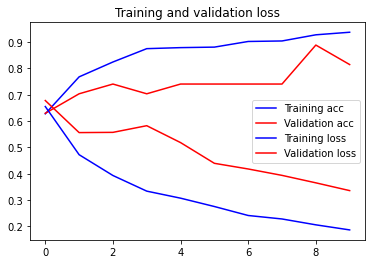

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()
 
plt.figure()

In [17]:
test_loss, test_acc = network.evaluate(test_data, test_labels, verbose=1) 
print("Test Accuracy:", test_acc)

6/6 [==============================] - 4s 654ms/step - loss: 0.7594 - accuracy: 0.7389
Test Accuracy: 0.7388888597488403


In [15]:
# network.save("ver2_mobilenetv2.h5")